# My Naive Bees Classifier for the The Metis Challenge
This is a documentation of my submission to the Naive Bees classification challenge, where I ended up on the second place (username frisbee). The challenge of the competition was to classify whether a bee is a honey bee (Apis) or a bumble bee (Bombus). According to the organizers, being able to identify bee species from images is a task that ultimately would allow researchers to more quickly and effectively collect field data. Pollinating bees have critical roles in both ecology and agriculture, and diseases like colony collapse disorder threaten these species. You can learn more about the challenge under http://www.drivendata.org/competitions/8/

My approach can be summarized as follows:
  * Train a deep convolutional neural network (DCNN) as classifier, which is based on the broadly used VGG16 architecture. This decision was based on an initial empirical comparison of different standard architectures (Inception, AlexNet, VGG16, VGG19), among which VGG16 performed best.
  * Initialize the DCNN with weights that have been obtained using pretraining on ImageNet. This decision was based on the fact that the competition's dataset is relatively small (for starting from scratch) and ImageNet has a considerable conceptual overlap with the competition (among others a class bee)
  * Fine-tune the DCNN to the Naive Bees classification challenge. Small learning rates and dropout +l2 regularization avoided overfitting of the large net to the small dataset. 
  * Online augmentation of training dataset based on zooming, rotating, translating, flipping, and stretching the training images randomly. This further reduced overfitting and increased the invariance of the model to certain transformations.
  * Use test-time augmentation for generation of predictions, based on generating 64 variations of each image based on zooming, rotating, and flipping. This reduced variance of the predictions and improved the relative ordering (AUC). Note that 8 variations would have been nearly as good and reduce computation time for prediction by a factor of 8.
  * Average predictions of an ensemble (size: 4) of DCNNs that have been trained as described above but with different random seed. Further reduce variance of predictions.

In [1]:
# We expect that there is a "persistency" directory containing all the required data 
# and models with the following structure:
# * SubmissionFormat.csv
# * train_labels.csv
# * vgg16_[0,1,2,3].pkl  (optional, if pretrained models should be used for prediction)
# * images/train/... (train images)
# * images/train/... (test images)
# * modelzoo/vgg16.pkl (Get from https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl)
# The path of the directory might be adapted:
persistency_dir = "/home/jmetzen/Temp/data/"

Let us first get some imports out of the way. You will need the following dependencies:
  * numpy
  * scipy
  * pandas
  * scikit-learn
  * theano
  * lasagne (using the revision 34fb8387e from github)
  * matplotlib (optional, only for plotting)
  * cuDNN (optional, otherwise the slower non-cuDNN convolutions and max-pooling from lasagne can be used)
  
This notebook has been executed sucessfully using the following versions (older and more recent version might also work):

In [2]:
# Note: if the IPython extension "watermark" is not installed, the following lines can be removed safely
%load_ext watermark
%watermark -a "Jan Hendrik Metzen" -d -v -m -p numpy,scipy,pandas,scikit-learn,theano,lasagne,matplotlib

Jan Hendrik Metzen 15/12/2015 

CPython 2.7.10
IPython 4.0.0

numpy 1.10.1
scipy 0.16.0
pandas 0.17.0
scikit-learn 0.17
theano 0.7.0
lasagne 0.2.dev1
matplotlib 1.4.3

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 3.13.0-37-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit


In [3]:
import os
import cPickle
import random

import numpy as np
from scipy.ndimage import imread
from scipy.misc import imresize
from scipy.special import logit, expit
import pandas as pd

from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split

import theano
import theano.tensor as T

import lasagne
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer, NonlinearityLayer
# If you don't have cuDNN installed, you may use:
# from lasagne.layers import MaxPool2DLayer as PoolLayer,  Conv2DLayer as ConvLayer
from lasagne.layers.dnn import MaxPool2DDNNLayer as PoolLayer,  Conv2DDNNLayer as ConvLayer
from lasagne.utils import floatX
from lasagne.nonlinearities import softmax
from lasagne.regularization import regularize_network_params, l2

%matplotlib inline
import matplotlib.pyplot as plt

# Try to make everything as reproducible as possible
np.random.seed(0)
random.seed(0)

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX 970 (CNMeM is disabled)


Now some parameters that need tuning:

In [4]:
# This batchsize is mainly due to GPU-memory restrictions (only 4GB RAM)
batch_size = 28  
# Learning rate was not heavily tuned; only such that the training does not diverge
learning_rate = 0.00005  
lr_decay_rate = 0.7
# The number of augmentations in test-time augmentation
# n_augmentations = 8 should give nearly as good results and speed up prediction by a factor of 8
n_augmentations = 64 
# The size of the ensemble. Larger values should increase performance due to reducing the variance in 
# predictions by averaging. This, however, comes at the cost of linearly increased training and prediction time
n_repetitions = 4 
# The number of training epochs
n_epochs = 35
# Weight decay strength (i.e. l2 penalty)
l2_regularization = 1e-3
# The ratio of the training data that is held out as validation data. Note that this data is 
# different for every repetition in ensembling
validation_size = 0.075
# Directory where all data (training, test data, learned models etc.) is loaded from and stored to
persistency_dir = "/home/jmetzen/Temp/data/"

# Data
Now let us load the data:

In [5]:
# load the labels using pandas
labels = pd.read_csv("%strain_labels.csv" % persistency_dir,
                     index_col=0)

submission_format = pd.read_csv("%sSubmissionFormat.csv" % persistency_dir,
                                index_col=0)

sf = pd.read_csv("%sSubmissionFormat.csv" % persistency_dir, index_col=0)

print "Number of training examples is: ", labels.shape[0]
print "Number of testing examples is: ", sf.shape[0]
print "Predictions should be type:", labels.dtypes[0]

Number of training examples is:  3969
Number of testing examples is:  992
Predictions should be type: float64


In [6]:
data_X = np.empty((labels.index.shape[0], 3, 224, 224), dtype=np.uint8)
data_X_test = np.empty((sf.index.shape[0], 3, 224, 224), dtype=np.uint8)

def load(img_id, phase):
    image = imread(('%s' + os.sep + 'images' + os.sep + "%s" + os.sep + '%s.jpg') 
                   % (persistency_dir, phase, img_id))
    image = imresize(image, (224, 224))
    image = image[:, :, :3]  # chop off alpha
    image = image[:, :, ::-1]  # convert to BGR
    return np.swapaxes(np.swapaxes(image, 1, 2), 0, 1)  # change to channel-first

for i, img_id in enumerate(labels.index):
    data_X[i] = load(img_id, "train")

for i, img_id in enumerate(sf.index):
    data_X_test[i] = load(img_id, "test")
    
data_y = np.array(labels, dtype=np.uint8)[:, 0]

Let us illustrate sixteen training images:

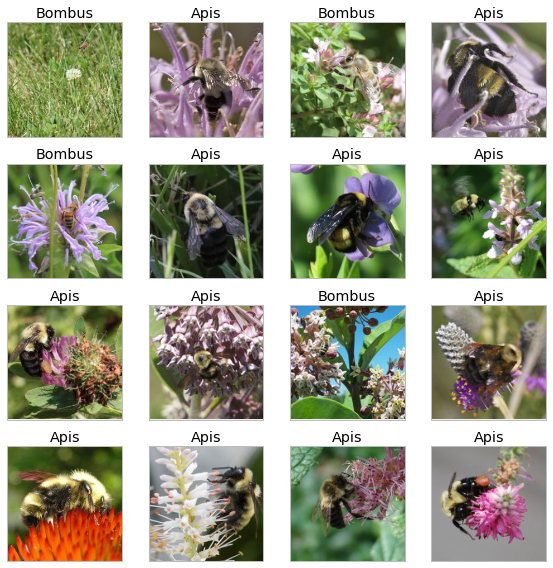

In [7]:
def plot_image(img):
    plt.imshow(np.swapaxes(np.swapaxes(img, 0, 1), 1, 2)[:, :, ::-1])
    plt.xticks([])
    plt.yticks([])
    
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plot_image(data_X[i+100])
    plt.title(["Bombus", "Apis"][data_y[i+100]])
plt.tight_layout()

We can see that there is considerable variation in the images and that it is difficult to tell the two classes apart.

# Model
Now, we create our deep neural network using the VGG16 architecture, and we initialize it with weights trained on ImageNet

In [8]:
def create_model():
    # Create model using the VGG_16 architecture
    # See https://raw.githubusercontent.com/Lasagne/Recipes/master/modelzoo/vgg16.py
    
    # VGG-16, 16-layer model from the paper:
    # "Very Deep Convolutional Networks for Large-Scale Image Recognition"
    # Original source: https://gist.github.com/ksimonyan/211839e770f7b538e2d8
    # License: non-commercial use only
    # If the restriction to non-commercial use poses a problem, you can retrain
    # the net on ImageNet without having to load pretrained weights
    pad = 1
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=pad)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=pad)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=pad)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=pad)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=pad)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=pad)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=pad)
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=pad)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=pad)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=pad)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=pad)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=pad)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=pad)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['drop6'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['drop6'], num_units=4096)
    net['drop7'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(net['drop7'], num_units=1000)
    # The fc9 layer is additional to the original VGG16 architecture and 
    # allows combining the pre-softmax outputs for the 1000 ImageNet classes
    # (fc8) into the two class probabilities for this problem
    net['fc9'] = DenseLayer(net['fc8'], num_units=2, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc9'], softmax)

    # Load weights for VGG16 that have been pretrained on ImageNet. Those 
    # can be downloaded from  https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl
    vgg_16 = cPickle.load(open('%smodelzoo/vgg16.pkl' % persistency_dir))
    lasagne.layers.set_all_param_values(net['fc8'], vgg_16['param values'])
    
    return net, np.array(vgg_16['mean value'], dtype=np.int16)

In [9]:
def get_train_eval(net):
    # Define the parameters to be adapted during training
    # Note that we fine-tune all layers except for 'conv1_1' and 'conv1_2'
    # The main reason for not adapting those layers is that this would have
    # required to reduce the batch_size further (for my 4GB GPU) and did not
    # result in a further improvement. If you want to fine-tune all layers,
    # you may use: model_params = lasagne.layers.get_all_params(net['prob'], trainable=True)
    model_params = [net['conv2_1'].W, net['conv2_1'].b,
                    net['conv2_2'].W, net['conv2_2'].b,
                    net['conv3_1'].W, net['conv3_1'].b,
                    net['conv3_2'].W, net['conv3_2'].b,
                    net['conv3_3'].W, net['conv3_3'].b,
                    net['conv4_1'].W, net['conv4_1'].b,
                    net['conv4_2'].W, net['conv4_2'].b,
                    net['conv4_3'].W, net['conv4_3'].b,
                    net['conv5_1'].W, net['conv5_1'].b,
                    net['conv5_2'].W, net['conv5_2'].b,
                    net['conv5_3'].W, net['conv5_3'].b,
                    net['fc6'].W, net['fc6'].b, 
                    net['fc7'].W, net['fc7'].b, 
                    net['fc8'].W, net['fc8'].b, 
                    net['fc9'].W, net['fc9'].b]
    feature_layer = net['fc8']
    output_layer = net['prob']

    X = T.tensor4()
    y = T.ivector()
    sh_lr = theano.shared(lasagne.utils.floatX(learning_rate))

    # training output (deterministic=False for dropout activated)
    output_train = lasagne.layers.get_output(output_layer, X, deterministic=False)
    # Our cost (loss) is the categorical crossentropy loss with weight decay (l2 penalty)
    cost = T.mean(T.nnet.categorical_crossentropy(output_train, y)) \
       + l2_regularization * regularize_network_params(output_layer, l2)
    # evaluation output (deterministic = False for dropout deactivated)
    output_eval, feature_eval = \
        lasagne.layers.get_output([output_layer, feature_layer], X, deterministic=True)
    # Use the ADAM optimizer for adapting network weights such that the loss is minimized 
    updates = lasagne.updates.adam(cost, model_params, learning_rate=sh_lr)

    # Define theano functions which can be used for training and evaluation of the
    # network
    train_fct = theano.function([X, y], [cost, output_train], updates=updates)
    eval_fct = theano.function([X], [output_eval, feature_eval])
    
    return train_fct, eval_fct, sh_lr

# Augmentation

We use data augmentation both in training and in validation/testing. The code for augmentation is heavily based on benanne's [solution](https://benanne.github.io/2015/03/17/plankton.html) to national data science bowl 2015, in particular this [file](https://raw.githubusercontent.com/benanne/kaggle-ndsb/master/data.py). Our code can be found [here](https://jmetzen.github.io/notebooks/augment.py).

In [10]:
from augment import perturb

# Parameters of augmentation used in testing (aug_params_test) have been
# tuned extensively on validation data and should be close to optimal for
# the data.

aug_params_test = {
    'zoom_range': (1, 1.5),  # We allow zooming-in with up-to a factor of 1.5
    'rotation_range': [0, 90, 180, 270], # we allow rotation by 0, 90, 180, and 270 degrees
    'shear_range': (0, 0), 
    'translation_range': (0, 0), 
    'do_flip': True,  # We allow flipping of data
    'allow_stretch': 1.0,
}

# Augmentation for validation is very similar to test augmentation;
# potentially aug_params_test would also be better suited for validation
# but there was a lack of time to rerun the training.

aug_params_valid = {
    'zoom_range': (1, 1.6), 
    'rotation_range': [0, 90, 180, 270],
    'shear_range': (0, 0), 
    'translation_range': (0, 0),
    'do_flip': True,
    'allow_stretch': 1 / 1.3,
}

# Augmentation for training was not heavily tuned (as it would be 
# computationally very expensive). In general, stronger variations
# in training than in testing seemed to be reasonable such that the
# CNN has to learn a greater range of invariances

aug_params_train = {
    'zoom_range': (1, 1.6), # We allow zooming-in with up-to a factor of 1.6
    'rotation_range': [0, 90, 180, 270], # we allow rotation by 0, 90, 180, and 270 degrees
    'shear_range': (0, 0),
    'translation_range': (-25, 25), # We allow translating the zoomed-in image by up to 25 pixels in each dimension
    'do_flip': True, # We allow flipping of data
    'allow_stretch': 1 / 1.3,  # We also allow stretching the image
}

Let us illustrate how (train) augmentation modifies a single training image (the upper left image shows the unmodified image):

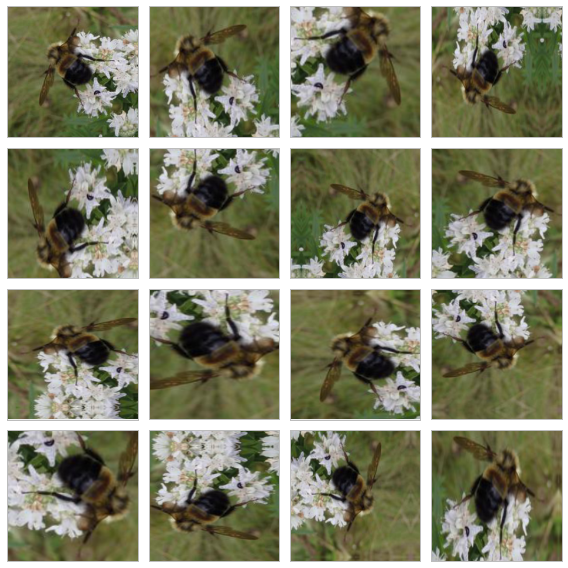

In [11]:
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    if i == 0:
        plot_image(data_X[0])
    else:
        plot_image(perturb(data_X[0], aug_params_train))
plt.tight_layout()

# Training and Evaluation
First some utility functions for training the net on data, predicting class labels for new data, and evaluating performance metrics on a hold-out valdiation data

In [12]:
def train_epoch(train_fct, X, y, mean_value, aug_params):
    # Function used for executing a single training epoch on (X, y) 
    # using the given augmentation parameters aug_params
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(batch_size)))
    # We use a different order of the training examples in each epoche
    permutation = np.random.permutation(num_samples) 
    
    # Collect costs and average ratio of correct classifications (accuracy)
    costs = []
    correct = 0
    for i in range(num_batches):   # train using minibatches
        idx = range(i*batch_size, np.minimum((i+1)*batch_size, num_samples))
        # Perform on-demand data augmentation (perturb each training data point 
        # randomly and differently in each epoch)
        X_batch = [perturb(X[permutation[ind]], aug_params) for ind in idx]
        X_batch = floatX(X_batch) - mean_value[:, np.newaxis, np.newaxis]
        y_batch = y[permutation[idx]]
        # Update the network
        cost_batch, output_train = train_fct(X_batch, y_batch)
        # Updated costs and correct count
        costs += [cost_batch]
        preds = np.argmax(output_train, axis=-1)
        correct += np.sum(y_batch == preds)

    # Return mean cost and correct ratio (accuracy) in epoch
    return np.mean(costs), correct / float(num_samples)

# Different merge functions that can be used for aggregating predictions
# of different test-time-augmentations of the same image
merge_fcts = {
    "mean": lambda x: np.mean(x, 1),
    "median": lambda x: np.median(x, 1),
    "logit_mean": lambda x: expit(np.mean(logit(x), 1))}

def predict(eval_fct, X, mean_value, aug_params, n_augmentations, merge_fct="logit_mean"):
    # Function used for predicting label of X using test-time
    # augmentation with aug_params and n_augmentations different 
    # perturbations for augmentation
    num_samples = X.shape[0]
    effective_batch_size = max(batch_size / n_augmentations, 1)
    num_batches = int(np.ceil(num_samples / float(effective_batch_size)))
    predictions = []
    for i in range(num_batches):  # predict mini-batches
        idx = range(i*effective_batch_size, 
                    np.minimum((i+1)*effective_batch_size, num_samples))
        # Generate test-time augmentations
        X_batch = [perturb(X[ind], aug_params)
                   for ind in idx for _ in range(n_augmentations)]
        X_batch = floatX(X_batch) - mean_value[:, np.newaxis, np.newaxis]
        # Generate predictions for each augmentation of the data point
        y_pred, _ = eval_fct(X_batch)
        predictions.extend(y_pred)   
    # Average predictions over all augmentations of a data point (image)
    # using merge function
    predictions = np.vstack(predictions)
    predictions = merge_fcts[merge_fct](predictions[:, 1].reshape(-1, n_augmentations))  
    return predictions

def eval_epoch(eval_fct, X, y, mean_value, aug_params, n_augmentations, merge_fct):
    # Method used for predicting labels for validation data X and
    # comparing with true label y
    # Generate predictions
    predictions = predict(eval_fct, X, mean_value, aug_params,
                          n_augmentations, merge_fct)
    # Compute accuracy and AUC on validation data using true labels
    acc = np.mean((predictions > 0.5) == y)
    false_positive_rate, true_positive_rate, thresholds = \
            roc_curve(y, predictions, pos_label=1)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    return acc, roc_auc

Now the function for fine-tuning the net for a certain number of epochs on thre training data:

In [13]:
def train_model(repetition, n_epochs):  
    # Train a model using n_epochs training epochs and use the repetition
    # as random seed
    # Split labeled data in training and validation data
    X_train, X_valid, y_train, y_valid = \
        train_test_split(data_X, data_y, test_size=validation_size, 
                         random_state=repetition, stratify=data_y)

    # Create model and obtain functions for training and evaluation of model
    model, mean_value = create_model()
    train_fct, eval_fct, sh_lr = get_train_eval(model)
        
    best_auc = 0.0
    best_params = None   
    for n in range(n_epochs):
        # Perform one training epoch
        train_cost, train_acc = train_epoch(train_fct, X_train, y_train,
                                            mean_value, aug_params_train)

        if (n+1) % 5 == 0:
            # Check every five episodes if AUC on validation data has improved
            # If yes: Remember the model's parameters
            valid_acc, valid_auc = \
                eval_epoch(eval_fct, X_valid, y_valid, mean_value,
                           aug_params_valid, n_augmentations=n_augmentations,
                           merge_fct="mean")

            print "Epoch {:d}: Train cost {:.3f}, Train acc {:.3f}, val acc {:.3f}, val AUC {:.3f}".format(
                n, train_cost, train_acc, valid_acc, valid_auc)

            if valid_auc > best_auc:
                best_params = lasagne.layers.get_all_param_values(model['fc9'])
                best_auc = valid_auc

            # Decay learning rate
            new_lr = sh_lr.get_value() * lr_decay_rate
            sh_lr.set_value(lasagne.utils.floatX(new_lr))
            
    # Return best parameters seen in any of the evaluations on the validation data
    return best_params

Finally the function to generate labels for test data:

In [14]:
def make_predictions(repetition, n_augmentations):   
    # Recreate pretrained model
    model, mean_value = create_model()
    _, eval_fct, _ = get_train_eval(model)
    param_values = cPickle.load(open('%svgg16_%s.pkl' 
                                     % (persistency_dir, repetition), 
                                     'rb'))
    lasagne.layers.set_all_param_values(model['fc9'], param_values)
    
    # Predict labels on test data
    return predict(eval_fct, data_X_test, mean_value, aug_params_test, 
                   n_augmentations, merge_fct="logit_mean")

We can not run the main code of the notebook, which (optionally) trains models on training data and evaluate model on test data.

In [15]:
# Run the actual training and prediction
do_train = True  # Set to True if the network should be trained, 
                 # False if pretrained networks should be used for prediction
preds = np.empty((data_X_test.shape[0], n_repetitions))
for repetition in range(n_repetitions):
    print "##### Repetition %s #####" % repetition
    np.random.seed(repetition) 
    random.seed(repetition)
    
    if do_train:    
        print "Train"
        param_values = train_model(repetition, n_epochs=n_epochs)
        cPickle.dump(param_values, open('%svgg16_%s.pkl' % (persistency_dir, repetition), 'wb'),
                     protocol=-1)
  
    np.random.seed(repetition)
    random.seed(repetition)

    print "Predict"
    preds[:, repetition] = make_predictions(repetition, n_augmentations)
    # copy the predictions to the dataframe with the ids and
    # write it out to a file
    prediction_df = sf.copy()
    prediction_df.genus = preds[:, repetition]
    prediction_df.to_csv("vgg_16_%d.csv" % repetition)

##### Repetition 0 #####
Train
Epoch 4: Train cost 1.934, Train acc 0.938, val acc 0.963, val AUC 0.991
Epoch 9: Train cost 1.595, Train acc 0.970, val acc 0.970, val AUC 0.993
Epoch 14: Train cost 1.432, Train acc 0.973, val acc 0.960, val AUC 0.990
Epoch 19: Train cost 1.302, Train acc 0.986, val acc 0.970, val AUC 0.990
Epoch 24: Train cost 1.231, Train acc 0.989, val acc 0.963, val AUC 0.991
Epoch 29: Train cost 1.195, Train acc 0.987, val acc 0.977, val AUC 0.992
Epoch 34: Train cost 1.137, Train acc 0.997, val acc 0.973, val AUC 0.990
Predict
##### Repetition 1 #####
Train
Epoch 4: Train cost 1.893, Train acc 0.887, val acc 0.909, val AUC 0.970
Epoch 9: Train cost 1.455, Train acc 0.949, val acc 0.950, val AUC 0.988
Epoch 14: Train cost 1.238, Train acc 0.963, val acc 0.963, val AUC 0.993
Epoch 19: Train cost 1.121, Train acc 0.973, val acc 0.943, val AUC 0.992
Epoch 24: Train cost 1.032, Train acc 0.984, val acc 0.966, val AUC 0.991
Epoch 29: Train cost 0.975, Train acc 0.988, v

In [16]:
# copy the predictions to the dataframe with the ids and
# write it out to a file
prediction_df = sf.copy()
prediction_df.genus = np.mean(preds, 1) 
prediction_df.to_csv("vgg_16_ensemble.csv")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database',)).History will not be written to the database.


Illustrate correlation and histogram of the predictions of the different models (requires seaborn):

/home/jmetzen/.anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


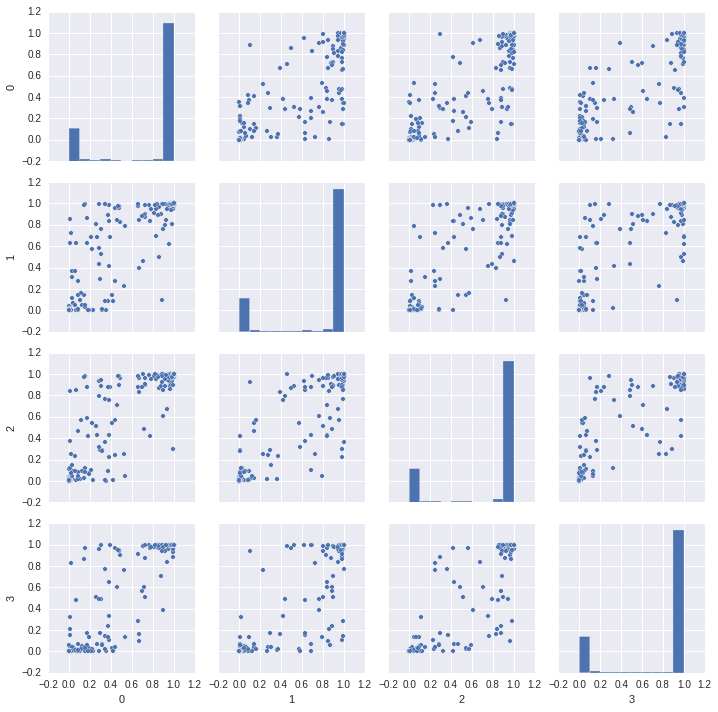

In [17]:
try:
    import seaborn as sns
    sns.pairplot(pd.DataFrame(preds))
except ImportError:
    pass

# Illustration of feature space

An illustration of the final feature map generated by the trained model on validation data, mpped to a 2d space by tSNE

In [18]:
repetition = 0

np.random.seed(repetition)
random.seed(repetition)

model, mean_value = create_model()
_, eval_fct, _ = get_train_eval(model)
param_values = cPickle.load(open('%svgg16_%s.pkl' % (persistency_dir, repetition), 'rb'))
lasagne.layers.set_all_param_values(model['fc9'], param_values)

_, X_valid, _, y_valid = \
    train_test_split(data_X, data_y, test_size=validation_size, 
                     random_state=repetition, stratify=data_y)

num_samples = X_valid.shape[0]
batch_size = 64
num_batches = int(np.ceil(num_samples / float(batch_size)))
output_features = []
for i in range(num_batches):
    idx = range(i*batch_size, np.minimum((i+1)*batch_size, num_samples))
    X_batch = [X_valid[ind] for ind in idx]
    X_batch = floatX(X_batch) - mean_value[:, np.newaxis, np.newaxis]
    _, features = eval_fct(X_batch)
    output_features.extend(features)   
output_features = np.vstack(output_features)

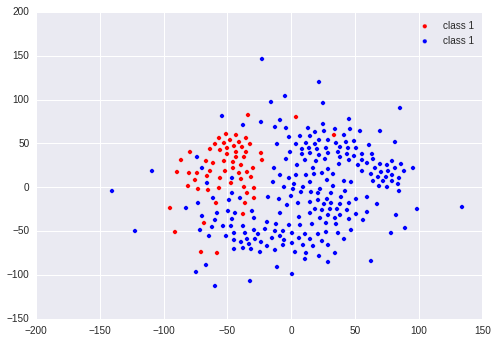

In [21]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0)
features_2D = tsne.fit_transform(output_features)
plt.scatter(features_2D[y_valid==0, 0], features_2D[y_valid==0, 1], c="r", label="class 1")
plt.scatter(features_2D[y_valid==1, 0], features_2D[y_valid==1, 1], c="b", label="class 1")
plt.legend()

We can see that the two classes are relatively well separated in the feature space induced by the DCNN. 